# Sanity Check of FedLeak (Resize Generator), ImageNet(ISLVRC2012).

Here is the sanity check on if FedLeak has been correctly trasferred.

We evaluate it with ***ImageNet(ISLVRC2012)***, with $5$ times sampling batch = $16$, reporting results in $5$ times recovery.
- *Evaluate times*: $5$.
- *Attack Target*: the averaged gradient from a sampled batch with $16$ datapoints.
- *How to sample*: the first $5$ batches from test-set, with `shuffle=False`.
- *Way to report*: PSNRs in $5$ times recovery, including the *max* value and the *median* value.

Codes are aligned with `sanity_check_resize_showcase.ipynb`, with `resize_generator.py` introduced.

### 🚩 1. Utils Importing

In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch, torchvision, argparse, os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

try:
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    os.chdir("..")
    
    import utils
    from criteria import *
    from utils import upscale, get_resnet18
    from resize_generator import FedLeak


def plot_images(images):
    plt.figure(figsize=(4, 3))
    
    images = images.clone().detach()
    images.mul(255).add_(0.5).clamp_(0, 255)
    images = images.to(dtype=torch.float32)

    grid_shape = int(torch.as_tensor(images.shape[0]).sqrt().ceil())
    _, axes = plt.subplots(grid_shape, grid_shape, figsize=(6, 6))
    for im, axis in zip(images, axes.flatten()):
        axis.imshow(im.permute(1, 2, 0).cpu())
        axis.axis("off")

    plt.show()


class ImageNet(torch.utils.data.Dataset):
    def __init__(self, dir="./imagenet/images", csv_path="./imagenet/images.csv", transforms=None):
        self.dir = dir
        self.csv = pd.read_csv(csv_path)
        self.transforms = transforms

    def __getitem__(self, index):
        img_obj = self.csv.loc[index]
        ImageID = img_obj['ImageId'] + '.png'
        Truelabel = img_obj['TrueLabel'] - 1
        img_path = os.path.join(self.dir, ImageID)
        pil_img = Image.open(img_path).convert('RGB')
        if self.transforms:
            data = self.transforms(pil_img)
        return data, Truelabel

    def __len__(self):
        return len(self.csv)

class NormalizedModel(torch.nn.Module):
    def __init__(self, model, mean, std, device):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.resize_op = torchvision.transforms.Resize((224, 224))
        self.mean, self.std = mean.to(device), std.to(device)

    def forward(self, x):
        x = self.resize_op(x)
        x = (x - self.mean) / self.std
        return self.model(x)


def get_client_gradient(data, label, model, loss_fn):
    loss = loss_fn(model(data), label)
    grads = torch.autograd.grad(loss, model.parameters())
    return grads


@torch.jit.script
def l1_loss(x, y):
    return (x-y).abs().mean()


def l2_loss(x, y):
    return (x-y).norm(2)


@torch.jit.script
def cos_loss(x, y):
    mask = x.abs().detach() >= x.detach().flatten().abs().quantile(0.2).item() # 只保留最小的百分之多少
    x, y = x * mask, y * mask
    return -(x.flatten() * y.flatten()).sum() / (x.flatten().norm(2)+1e-8) / (y.flatten().norm(2)+1e-8)


@torch.jit.script
def combine_loss(x, y):
    mask = (y.abs() >= torch.quantile(y.abs(), 0.5).item()).float()
    x, y = mask * x, mask * y
    return l1_loss(x, y) + cos_loss(x, y)

### 🚩 2. Data Loading

In [2]:
seed = 2025
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
device = torch.device(f"cuda:2")
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize((128, 128))
])

dataset = torchvision.datasets.ImageNet(root="~/data/imagenet/", split="val", transform=transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)
loader_iter = iter(trainloader)

### 🚩 3. Attack for five times

In [3]:
# define utils
import statistics
def print_psnrs(psnrs):
    median_psnr = statistics.mean(psnrs)
    best_psnr = max(psnrs)
    print(f"BEST PSNR: {best_psnr:6.4f}")
    print(f"MEDIAN PSNR: {median_psnr:6.4f}")
    
    print("ALL PSNR: [", end="")
    for p in psnrs[0:-1]:
        print(f"{p:6.4f}, ", end="")
    print(f"{p:6.4f}]")

#### ⭕ 3.1 Times 1

True Data:


<Figure size 400x300 with 0 Axes>

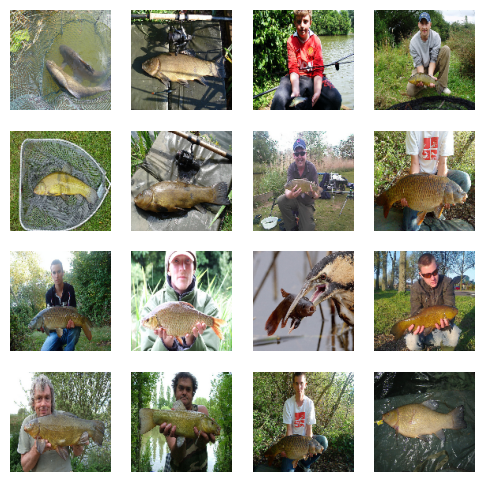

| It: 1 | Loss: -44.0058 | Time:   4.94s |


| It: 1001 | Loss: -60.7500 | Time: 658.23s |


| It: 2001 | Loss: -61.3211 | Time: 663.45s |


| It: 3001 | Loss: -61.5005 | Time: 674.68s |


| It: 4001 | Loss: -61.6057 | Time: 669.83s |


| It: 5001 | Loss: -61.6709 | Time: 671.41s |


| It: 6001 | Loss: -61.7220 | Time: 669.53s |


| It: 7001 | Loss: -61.7618 | Time: 666.23s |


| It: 8001 | Loss: -61.7879 | Time: 668.30s |


| It: 9001 | Loss: -61.8006 | Time: 668.32s |


| It: 1 | Loss: -44.1201 | Time:   0.68s |


| It: 1001 | Loss: -60.6676 | Time: 668.41s |


| It: 2001 | Loss: -61.2736 | Time: 668.20s |


| It: 3001 | Loss: -61.4743 | Time: 667.01s |


| It: 4001 | Loss: -61.5784 | Time: 669.38s |


| It: 5001 | Loss: -61.6477 | Time: 667.47s |


| It: 6001 | Loss: -61.7034 | Time: 667.43s |


| It: 7001 | Loss: -61.7468 | Time: 668.82s |


| It: 8001 | Loss: -61.7738 | Time: 665.75s |


| It: 9001 | Loss: -61.7870 | Time: 668.47s |


| It: 1 | Loss: -42.2891 | Time:   0.70s |


| It: 1001 | Loss: -60.6386 | Time: 670.21s |


| It: 2001 | Loss: -61.2470 | Time: 672.74s |


| It: 3001 | Loss: -61.4588 | Time: 672.89s |


| It: 4001 | Loss: -61.5633 | Time: 671.78s |


| It: 5001 | Loss: -61.6471 | Time: 673.49s |


| It: 6001 | Loss: -61.7027 | Time: 668.86s |


| It: 7001 | Loss: -61.7471 | Time: 668.16s |


| It: 8001 | Loss: -61.7749 | Time: 668.06s |


| It: 9001 | Loss: -61.7896 | Time: 672.09s |


| It: 1 | Loss: -43.6333 | Time:   0.70s |


| It: 1001 | Loss: -60.2178 | Time: 671.41s |


| It: 2001 | Loss: -61.0481 | Time: 665.64s |


| It: 3001 | Loss: -61.3376 | Time: 663.59s |


| It: 4001 | Loss: -61.4976 | Time: 668.76s |


| It: 5001 | Loss: -61.5907 | Time: 667.17s |


| It: 6001 | Loss: -61.6604 | Time: 668.01s |


| It: 7001 | Loss: -61.7136 | Time: 671.60s |


| It: 8001 | Loss: -61.7457 | Time: 669.60s |


| It: 9001 | Loss: -61.7632 | Time: 671.39s |


| It: 1 | Loss: -42.3394 | Time:   0.70s |


| It: 1001 | Loss: -60.6485 | Time: 670.71s |


| It: 2001 | Loss: -61.2515 | Time: 666.60s |


| It: 3001 | Loss: -61.4616 | Time: 659.81s |


| It: 4001 | Loss: -61.5790 | Time: 661.59s |


| It: 5001 | Loss: -61.6564 | Time: 669.34s |


| It: 6001 | Loss: -61.7098 | Time: 666.76s |


| It: 7001 | Loss: -61.7489 | Time: 666.34s |


| It: 8001 | Loss: -61.7768 | Time: 662.11s |


| It: 9001 | Loss: -61.7915 | Time: 662.30s |


BEST PSNR: 10.7518
MEDIAN PSNR: 10.4851
ALL PSNR: [10.5645, 10.2119, 10.4899, 10.7518, 10.7518]


<Figure size 400x300 with 0 Axes>

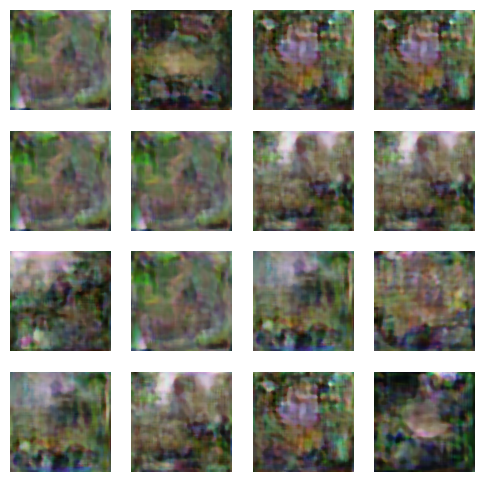

In [4]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.2 Times 2

True Data:


<Figure size 400x300 with 0 Axes>

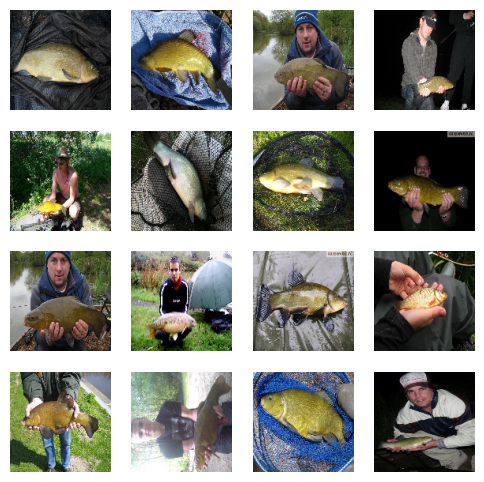

| It: 1 | Loss: -42.4737 | Time:   0.71s |


| It: 1001 | Loss: -60.6634 | Time: 663.26s |


| It: 2001 | Loss: -61.2676 | Time: 657.83s |


| It: 3001 | Loss: -61.4748 | Time: 648.29s |


| It: 4001 | Loss: -61.5836 | Time: 651.54s |


| It: 5001 | Loss: -61.6572 | Time: 646.44s |


| It: 6001 | Loss: -61.7101 | Time: 647.89s |


| It: 7001 | Loss: -61.7529 | Time: 654.80s |


| It: 8001 | Loss: -61.7801 | Time: 653.15s |


| It: 9001 | Loss: -61.7931 | Time: 653.71s |


| It: 1 | Loss: -43.0275 | Time:   0.69s |


| It: 1001 | Loss: -60.8421 | Time: 656.82s |


| It: 2001 | Loss: -61.3703 | Time: 653.91s |


| It: 3001 | Loss: -61.5211 | Time: 654.60s |


| It: 4001 | Loss: -61.6222 | Time: 659.74s |


| It: 5001 | Loss: -61.6823 | Time: 655.11s |


| It: 6001 | Loss: -61.7353 | Time: 654.78s |


| It: 7001 | Loss: -61.7701 | Time: 657.96s |


| It: 8001 | Loss: -61.7962 | Time: 657.84s |


| It: 9001 | Loss: -61.8078 | Time: 660.44s |


| It: 1 | Loss: -43.6304 | Time:   0.67s |


| It: 1001 | Loss: -60.7744 | Time: 652.55s |


| It: 2001 | Loss: -61.2592 | Time: 655.91s |


| It: 3001 | Loss: -61.4806 | Time: 659.49s |


| It: 4001 | Loss: -61.5811 | Time: 655.27s |


| It: 5001 | Loss: -61.6489 | Time: 653.88s |


| It: 6001 | Loss: -61.7102 | Time: 658.15s |


| It: 7001 | Loss: -61.7521 | Time: 655.22s |


| It: 8001 | Loss: -61.7799 | Time: 650.05s |


| It: 9001 | Loss: -61.7928 | Time: 653.83s |


| It: 1 | Loss: -41.2940 | Time:   0.66s |


| It: 1001 | Loss: -60.7860 | Time: 649.56s |


| It: 2001 | Loss: -61.3022 | Time: 653.89s |


| It: 3001 | Loss: -61.4859 | Time: 654.19s |


| It: 4001 | Loss: -61.6063 | Time: 655.98s |


| It: 5001 | Loss: -61.6818 | Time: 652.73s |


| It: 6001 | Loss: -61.7331 | Time: 652.32s |


| It: 7001 | Loss: -61.7704 | Time: 647.62s |


| It: 8001 | Loss: -61.7970 | Time: 646.93s |


| It: 9001 | Loss: -61.8113 | Time: 646.91s |


| It: 1 | Loss: -44.2906 | Time:   0.66s |


| It: 1001 | Loss: -60.9461 | Time: 651.22s |


| It: 2001 | Loss: -61.3848 | Time: 653.51s |


| It: 3001 | Loss: -61.5487 | Time: 653.25s |


| It: 4001 | Loss: -61.6312 | Time: 651.64s |


| It: 5001 | Loss: -61.6989 | Time: 654.39s |


| It: 6001 | Loss: -61.7422 | Time: 652.73s |


| It: 7001 | Loss: -61.7785 | Time: 651.35s |


| It: 8001 | Loss: -61.8029 | Time: 652.86s |


| It: 9001 | Loss: -61.8152 | Time: 651.36s |


BEST PSNR: 10.0082
MEDIAN PSNR: 9.8059
ALL PSNR: [9.7328, 9.9103, 10.0082, 9.7906, 9.7906]


<Figure size 400x300 with 0 Axes>

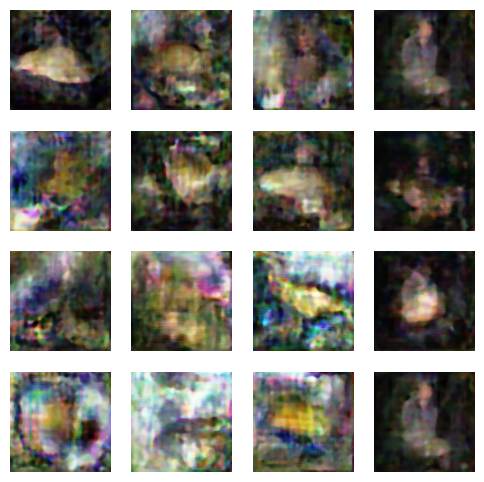

In [5]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.3 Times 3

True Data:


<Figure size 400x300 with 0 Axes>

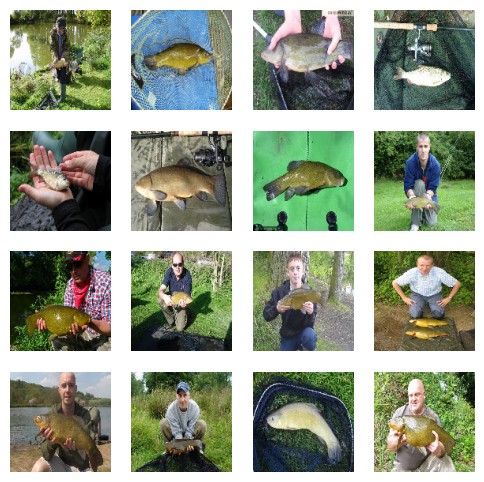

| It: 1 | Loss: -41.7403 | Time:   0.61s |


| It: 1001 | Loss: -60.9005 | Time: 652.34s |


| It: 2001 | Loss: -61.4063 | Time: 654.15s |


| It: 3001 | Loss: -61.5554 | Time: 652.42s |


| It: 4001 | Loss: -61.6499 | Time: 652.90s |


| It: 5001 | Loss: -61.7125 | Time: 655.24s |


| It: 6001 | Loss: -61.7547 | Time: 651.98s |


| It: 7001 | Loss: -61.7895 | Time: 655.29s |


| It: 8001 | Loss: -61.8129 | Time: 652.43s |


| It: 9001 | Loss: -61.8241 | Time: 653.61s |


| It: 1 | Loss: -41.8684 | Time:   0.67s |


| It: 1001 | Loss: -60.9238 | Time: 651.85s |


| It: 2001 | Loss: -61.3699 | Time: 653.56s |


| It: 3001 | Loss: -61.5478 | Time: 654.46s |


| It: 4001 | Loss: -61.6369 | Time: 652.16s |


| It: 5001 | Loss: -61.7033 | Time: 653.07s |


| It: 6001 | Loss: -61.7495 | Time: 654.60s |


| It: 7001 | Loss: -61.7837 | Time: 652.54s |


| It: 8001 | Loss: -61.8071 | Time: 653.84s |


| It: 9001 | Loss: -61.8190 | Time: 654.55s |


| It: 1 | Loss: -43.7183 | Time:   0.66s |


| It: 1001 | Loss: -60.9283 | Time: 654.08s |


| It: 2001 | Loss: -61.3903 | Time: 654.35s |


| It: 3001 | Loss: -61.5360 | Time: 651.87s |


| It: 4001 | Loss: -61.6328 | Time: 654.64s |


| It: 5001 | Loss: -61.6939 | Time: 654.20s |


| It: 6001 | Loss: -61.7456 | Time: 650.20s |


| It: 7001 | Loss: -61.7805 | Time: 643.47s |


| It: 8001 | Loss: -61.8049 | Time: 654.84s |


| It: 9001 | Loss: -61.8164 | Time: 652.47s |


| It: 1 | Loss: -44.1277 | Time:   0.67s |


| It: 1001 | Loss: -60.8966 | Time: 655.13s |


| It: 2001 | Loss: -61.4114 | Time: 649.78s |


| It: 3001 | Loss: -61.5555 | Time: 648.83s |


| It: 4001 | Loss: -61.6442 | Time: 650.77s |


| It: 5001 | Loss: -61.7055 | Time: 651.03s |


| It: 6001 | Loss: -61.7501 | Time: 651.92s |


| It: 7001 | Loss: -61.7832 | Time: 655.42s |


| It: 8001 | Loss: -61.8067 | Time: 652.82s |


| It: 9001 | Loss: -61.8184 | Time: 649.65s |


| It: 1 | Loss: -41.9956 | Time:   0.66s |


| It: 1001 | Loss: -61.0574 | Time: 654.10s |


| It: 2001 | Loss: -61.4504 | Time: 650.36s |


| It: 3001 | Loss: -61.5872 | Time: 655.15s |


| It: 4001 | Loss: -61.6674 | Time: 653.30s |


| It: 5001 | Loss: -61.7197 | Time: 649.54s |


| It: 6001 | Loss: -61.7633 | Time: 652.09s |


| It: 7001 | Loss: -61.7946 | Time: 654.58s |


| It: 8001 | Loss: -61.8155 | Time: 650.40s |


| It: 9001 | Loss: -61.8280 | Time: 649.22s |


BEST PSNR: 10.5689
MEDIAN PSNR: 10.4470
ALL PSNR: [10.4999, 10.4945, 10.2609, 10.5689, 10.5689]


<Figure size 400x300 with 0 Axes>

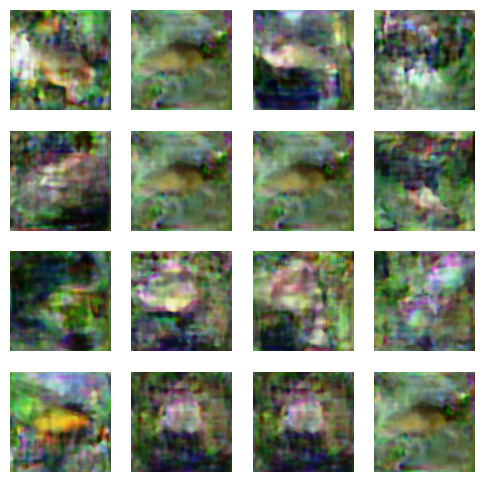

In [6]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.4 Times 4

True Data:


<Figure size 400x300 with 0 Axes>

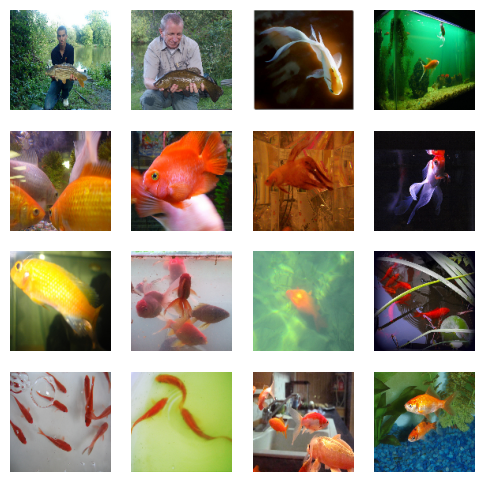

| It: 1 | Loss: -21.7526 | Time:   0.64s |


| It: 1001 | Loss: -61.0329 | Time: 651.66s |


| It: 2001 | Loss: -61.5243 | Time: 648.97s |


| It: 3001 | Loss: -61.6893 | Time: 653.89s |


| It: 4001 | Loss: -61.7620 | Time: 653.13s |


| It: 5001 | Loss: -61.8143 | Time: 648.80s |


| It: 6001 | Loss: -61.8516 | Time: 652.35s |


| It: 7001 | Loss: -61.8779 | Time: 653.21s |


| It: 8001 | Loss: -61.8956 | Time: 649.02s |


| It: 9001 | Loss: -61.9048 | Time: 649.69s |


| It: 1 | Loss: -12.8611 | Time:   0.66s |


| It: 1001 | Loss: -60.9284 | Time: 651.41s |


| It: 2001 | Loss: -61.4351 | Time: 648.66s |


| It: 3001 | Loss: -61.6090 | Time: 653.92s |


| It: 4001 | Loss: -61.7256 | Time: 652.77s |


| It: 5001 | Loss: -61.7889 | Time: 648.77s |


| It: 6001 | Loss: -61.8360 | Time: 651.18s |


| It: 7001 | Loss: -61.8671 | Time: 654.65s |


| It: 8001 | Loss: -61.8875 | Time: 650.97s |


| It: 9001 | Loss: -61.8961 | Time: 649.98s |


| It: 1 | Loss: -31.5432 | Time:   0.67s |


| It: 1001 | Loss: -61.0060 | Time: 651.37s |


| It: 2001 | Loss: -61.5424 | Time: 647.42s |


| It: 3001 | Loss: -61.7042 | Time: 649.01s |


| It: 4001 | Loss: -61.7736 | Time: 653.36s |


| It: 5001 | Loss: -61.8234 | Time: 650.19s |


| It: 6001 | Loss: -61.8578 | Time: 649.60s |


| It: 7001 | Loss: -61.8840 | Time: 655.36s |


| It: 8001 | Loss: -61.9011 | Time: 654.07s |


| It: 9001 | Loss: -61.9099 | Time: 658.76s |


| It: 1 | Loss: -25.5658 | Time:   0.66s |


| It: 1001 | Loss: -61.1119 | Time: 653.10s |


| It: 2001 | Loss: -61.5446 | Time: 654.15s |


| It: 3001 | Loss: -61.6974 | Time: 650.45s |


| It: 4001 | Loss: -61.7762 | Time: 651.15s |


| It: 5001 | Loss: -61.8263 | Time: 655.28s |


| It: 6001 | Loss: -61.8640 | Time: 652.19s |


| It: 7001 | Loss: -61.8901 | Time: 649.56s |


| It: 8001 | Loss: -61.9077 | Time: 653.12s |


| It: 9001 | Loss: -61.9165 | Time: 657.06s |


| It: 1 | Loss: -26.7329 | Time:   0.67s |


| It: 1001 | Loss: -61.1101 | Time: 649.02s |


| It: 2001 | Loss: -61.5224 | Time: 651.72s |


| It: 3001 | Loss: -61.6620 | Time: 655.10s |


| It: 4001 | Loss: -61.7518 | Time: 650.97s |


| It: 5001 | Loss: -61.8118 | Time: 648.89s |


| It: 6001 | Loss: -61.8527 | Time: 652.05s |


| It: 7001 | Loss: -61.8822 | Time: 655.05s |


| It: 8001 | Loss: -61.9013 | Time: 652.05s |


| It: 9001 | Loss: -61.9107 | Time: 650.45s |


BEST PSNR: 11.4826
MEDIAN PSNR: 10.8602
ALL PSNR: [10.5703, 11.4037, 10.7806, 11.4826, 11.4826]


<Figure size 400x300 with 0 Axes>

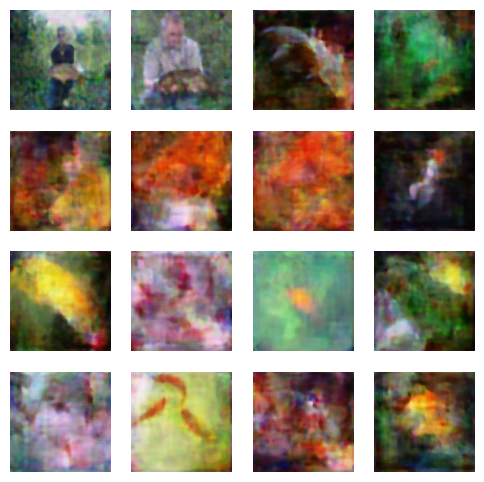

In [7]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)

#### ⭕ 3.5 Times 5

True Data:


<Figure size 400x300 with 0 Axes>

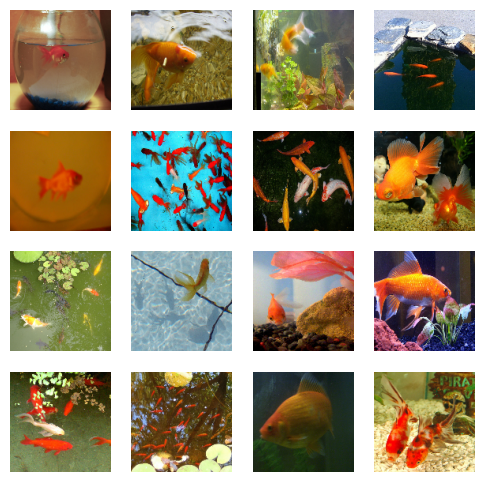

| It: 1 | Loss: -45.1297 | Time:   0.68s |


| It: 1001 | Loss: -61.0654 | Time: 653.15s |


| It: 2001 | Loss: -61.4465 | Time: 649.28s |


| It: 3001 | Loss: -61.6065 | Time: 648.28s |


| It: 4001 | Loss: -61.6921 | Time: 650.37s |


| It: 5001 | Loss: -61.7451 | Time: 654.06s |


| It: 6001 | Loss: -61.7889 | Time: 648.95s |


| It: 7001 | Loss: -61.8184 | Time: 650.01s |


| It: 8001 | Loss: -61.8402 | Time: 655.19s |


| It: 9001 | Loss: -61.8502 | Time: 652.07s |


| It: 1 | Loss: -45.2297 | Time:   0.66s |


| It: 1001 | Loss: -61.1564 | Time: 651.36s |


| It: 2001 | Loss: -61.4964 | Time: 654.60s |


| It: 3001 | Loss: -61.6314 | Time: 650.28s |


| It: 4001 | Loss: -61.7022 | Time: 648.54s |


| It: 5001 | Loss: -61.7529 | Time: 648.86s |


| It: 6001 | Loss: -61.7933 | Time: 655.03s |


| It: 7001 | Loss: -61.8220 | Time: 652.55s |


| It: 8001 | Loss: -61.8424 | Time: 649.60s |


| It: 9001 | Loss: -61.8524 | Time: 648.56s |


| It: 1 | Loss: -45.3087 | Time:   0.66s |


| It: 1001 | Loss: -61.0558 | Time: 653.75s |


| It: 2001 | Loss: -61.4514 | Time: 649.33s |


| It: 3001 | Loss: -61.6071 | Time: 650.76s |


| It: 4001 | Loss: -61.6909 | Time: 655.30s |


| It: 5001 | Loss: -61.7461 | Time: 651.70s |


| It: 6001 | Loss: -61.7898 | Time: 649.54s |


| It: 7001 | Loss: -61.8201 | Time: 653.81s |


| It: 8001 | Loss: -61.8407 | Time: 653.77s |


| It: 9001 | Loss: -61.8505 | Time: 650.33s |


| It: 1 | Loss: -45.3609 | Time:   0.67s |


| It: 1001 | Loss: -61.0072 | Time: 655.43s |


| It: 2001 | Loss: -61.4500 | Time: 651.86s |


| It: 3001 | Loss: -61.5892 | Time: 651.32s |


| It: 4001 | Loss: -61.6795 | Time: 656.14s |


| It: 5001 | Loss: -61.7358 | Time: 652.42s |


| It: 6001 | Loss: -61.7771 | Time: 649.93s |


| It: 7001 | Loss: -61.8105 | Time: 649.10s |


| It: 8001 | Loss: -61.8316 | Time: 653.57s |


| It: 9001 | Loss: -61.8418 | Time: 654.43s |


| It: 1 | Loss: -45.2936 | Time:   0.67s |


| It: 1001 | Loss: -61.1682 | Time: 649.71s |


| It: 2001 | Loss: -61.5093 | Time: 649.33s |


| It: 3001 | Loss: -61.6571 | Time: 655.17s |


| It: 4001 | Loss: -61.7224 | Time: 653.75s |


| It: 5001 | Loss: -61.7704 | Time: 650.84s |


| It: 6001 | Loss: -61.8051 | Time: 649.73s |


| It: 7001 | Loss: -61.8335 | Time: 649.31s |


| It: 8001 | Loss: -61.8513 | Time: 654.39s |


| It: 9001 | Loss: -61.8603 | Time: 654.60s |


BEST PSNR: 11.0683
MEDIAN PSNR: 10.2267
ALL PSNR: [10.0517, 10.6165, 9.5821, 9.8147, 9.8147]


<Figure size 400x300 with 0 Axes>

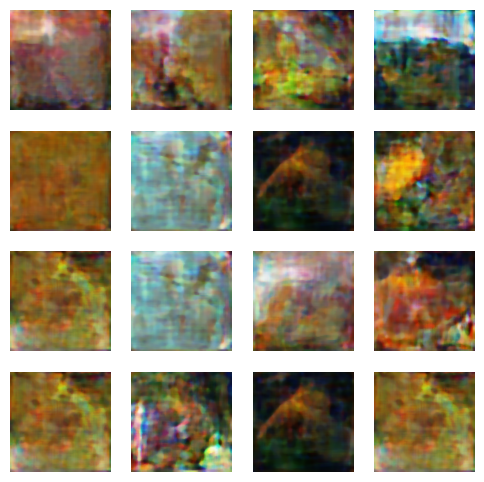

In [8]:
model = get_resnet18().to(device)
loss_func = torch.nn.CrossEntropyLoss()
data, label = next(loader_iter)
data, label = data.to(device), label.to(device)
client_grads = get_client_gradient(data, label, model, torch.nn.CrossEntropyLoss())
client_grads = [grad.clone() for grad in client_grads]
print(f"True Data:")
plot_images(data)

data = upscale(data)
best_ones_PSNR = torch.zeros_like(data)
best_ones_SSIM = torch.zeros_like(data)
best_ones_LPIPS = torch.zeros_like(data)
psnrs = []

for _ in range(5): # restart for better attack performance.
    recovered_images = FedLeak(client_grads, label, model, combine_loss, device=device)
    psnr = compute_psnr(data, recovered_images, False).mean().item()
    psnrs.append(psnr)
    best_ones_PSNR = update_best_ones(best_ones_PSNR, data, recovered_images, "PSNR")

print_psnrs(psnrs)
plot_images(best_ones_PSNR)